# First neural network

In this project, was built an initial neural network (shallow) used to predict pass through medicines. Was provided a relation of 2 quarter (7 months) of stock with ARIMA prediction & a quarter prediction (2018/03).



In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import *

## Load and prepare the data

A critical step in working with neural networks is preparing the data correctly. Variables on different scales make it difficult for the network to efficiently learn the correct weights. Below, we've written the code to load and prepare the data. You'll learn more about this soon!

In [2]:
count1 = 'ABATACEPTE 125 MG/ML' # SOL INJ (SER PREENC) 1 ML GRUPO 1.A
count2 = 'ABATACEPTE 250 MG Pó' #  P/ SUSP INJ (FR-AMP) GRUPO 1.A
data_path = 'data/normalized_full.csv'
medicines = pd.read_csv(data_path)
medicines.head()

,uf,dtmonth,count1,count2,predicted,delivered
0,Acre,2017-01,94,94,NaN,NaN
1,Acre,2017-02,53,53,NaN,NaN
2,Acre,2017-03,94,94,NaN,NaN
3,Acre,2017-04,218,218,NaN,NaN
4,Acre,2017-05,222,222,NaN,NaN


## Checking out the data

This dataset has the number of medicines acquired by Health Ministery for each month of each day from January 1 2017 to November 31 2018. The number of medicines is split between casual and registered, summed up in the `count1` column. You can see the first few rows of the data above.

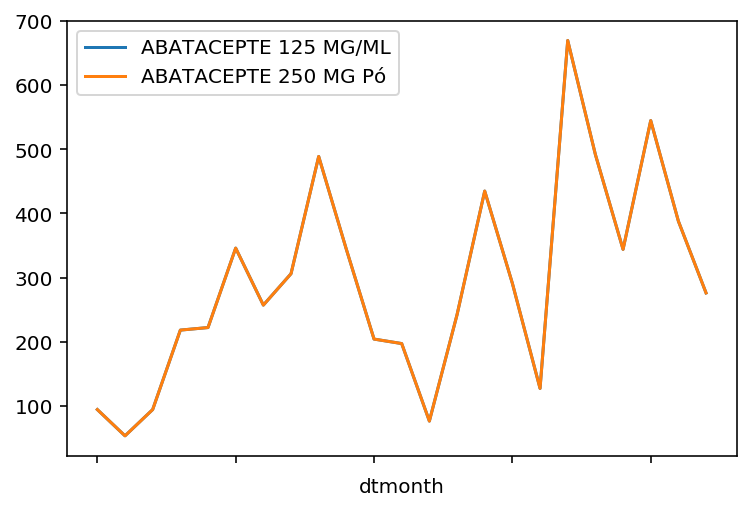

In [3]:
fig, ax = subplots()
medicines[:].plot(x='dtmonth', y=['count1', 'count2'], ax=ax)
ax.legend([count1, count2]);

### Dummy variables
Here we have some categorical variables like __predicted__ and __delivered__. To include these variables is necessary to make it binary dummy variables. This is simple to do with Pandas thanks to `get_dummies()`.

In [4]:
# Convert dtmonth to index month ignoring it year
medicines['dtmonth'] = medicines['dtmonth'].apply(lambda x: int(x.split('-')[1]))

dummy_fields = ['predicted', 'delivered', 'uf']
for each in dummy_fields:
    dummies = pd.get_dummies(medicines[each], prefix=each, drop_first=False)
    medicines = pd.concat([medicines, dummies], axis=1)


fields_to_drop = ['predicted', 'delivered', 'uf']
data = medicines.drop(fields_to_drop, axis=1)
data.head()

,dtmonth,count1,count2,predicted_85.0,predicted_113.0,delivered_256.0,delivered_340.0,uf_Acre
0,1,94,94,0,0,0,0,1
1,2,53,53,0,0,0,0,1
2,3,94,94,0,0,0,0,1
3,4,218,218,0,0,0,0,1
4,5,222,222,0,0,0,0,1


### Scaling target variables
To make training the network easier, we'll standardize each of the continuous variables. That is, we'll shift and scale the variables such that they have zero mean and a standard deviation of 1.

The scaling factors are saved so we can go backwards when we use the network for predictions.

In [5]:
quant_features = ['dtmonth', 'count1']
# Store scalings in a dictionary so we can convert back later
scaled_features = {}
for each in quant_features:
    mean, std = data[each].mean(), data[each].std()
    scaled_features[each] = [mean, std]
    data.loc[:, each] = (data[each] - mean)/std

print('passed')

passed


### Splitting the data into training, testing, and validation sets

We'll save the data for the last approximately 2 months to use as a test set after we've trained the network. We'll use this set to make predictions and compare them with the actual number of medicines.

In [6]:
# Save data for approximately the last 2 months 
test_data = data[-2*1:]

# Now remove the test data from the data set 
data = data[:-2*1]

# Separate the data into features and targets
target_fields = ['count1'] #, 'count2'
features, targets = data.drop(target_fields, axis=1), data[target_fields] # features(inputs) = data except targets
test_features, test_targets = test_data.drop(target_fields, axis=1), test_data[target_fields]

test_data.head()

,dtmonth,count1,count2,predicted_85.0,predicted_113.0,delivered_256.0,delivered_340.0,uf_Acre
21,1.099496,0.600979,388,1,0,1,0,1
22,1.393547,-0.098263,276,0,1,0,1,1


We'll split the data into two sets, one for training and one for validating as the network is being trained. Since this is time series data, we'll train on historical data, then try to predict on future data (the validation set).

In [7]:
# Hold out the last 8 months or so of the remaining data as a validation set
train_features, train_targets = features[:-2*8], targets[:-2*8]
val_features, val_targets = features[-2*8:], targets[-2*8:]

## Time to build the network

Below you'll build your network. We've built out the structure and the backwards pass. __You'll implement__ the __forward pass__ through the network. __You'll__ also __set__ the hyperparameters: __the learning rate__, the __number of hidden units__, and the __number of training passes__.

The network has two layers: a __hidden__ layer and an __output__ layer. The __hidden__ layer will use the __sigmoid function for activations__. The __output__ layer has only one node and is __used for the regression__, the __output__ of the node __is the same as the input__ of the node. That is, __the activation function is $f(x)=x$__. A function that takes the input signal and generates an output signal, but takes into account the threshold, is called an activation function. We work through each layer of our network calculating the outputs for each neuron. All of the __outputs from one layer become inputs to the neurons on the next layer__. This process is __called *forward propagation*__.

We __use__ the __weights__ to __propagate signals forward__ from the __input to the output__ layers in a neural network. We use the __weights__ to __also propagate error backwards__ from the __output back__ into the network to update our weights. This is called __*backpropagation*__.

> **Hint:** You'll need the derivative of the output activation function ($f(x) = x$) for the backpropagation implementation. If you aren't familiar with calculus, this function is equivalent to the equation $y = x$. What is the slope of that equation? That is the derivative of $f(x)$.

Below, you have these tasks:
1. Implement the sigmoid function to use as the activation function. Set `self.activation_function` in `__init__` to your sigmoid function.
2. Implement the forward pass in the `train` method.
3. Implement the backpropagation algorithm in the `train` method, including calculating the output error.
4. Implement the forward pass in the `run` method.
  

In [8]:
class NeuralNetwork(object):
    def __init__(self, input_nodes, hidden_nodes, output_nodes, learning_rate):
        # Set number of nodes in input, hidden and output layers.
        self.input_nodes = input_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes

        # Initialize weights
        self.weights_input_to_hidden = np.random.normal(0.0, self.hidden_nodes ** -0.5,
                                                        (self.hidden_nodes, self.input_nodes))

        self.weights_hidden_to_output = np.random.normal(0.0, self.output_nodes ** -0.5,
                                                         (self.output_nodes, self.hidden_nodes))
        self.lr = learning_rate

        #### TODO: Set self.activation_function to your implemented sigmoid function ####
        #
        # Note: in Python, you can define a function with a lambda expression,
        # as shown below.
        self.activation_function = lambda x: 1 / (1 + np.exp(-x))
        self.activation_function_prime = lambda x: x*1

        ### If the lambda code above is not something you're familiar with,
        # You can uncomment out the following three lines and put your
        # implementation there instead.
        #
        # def sigmoid(x):
        #    return 0  # Replace 0 with your sigmoid calculation here
        # self.activation_function = sigmoid

    def train(self, inputs_list, targets_list):
        # Convert inputs list to 2d array
        inputs = np.array(inputs_list, ndmin=2).T
        targets = np.array(targets_list, ndmin=2).T

        #### Implement the forward pass here ####
        ### Forward pass ###
        # TODO: Hidden layer - Replace these values with your calculations.
        # weights is (n x 56), (a set of weights for each hidden node)
        # hidden inputs linear combination & generating activated output
        hidden_inputs = np.dot(self.weights_input_to_hidden, inputs)  # signals into hidden layer
        hidden_outputs = self.activation_function(hidden_inputs)  # signals from hidden layer

        # TODO: Output layer - Replace these values with your calculations.
        # values on output layer (end nodes), same steps before (linear_comb+activation) using out_refs
        final_inputs = np.dot(self.weights_hidden_to_output, hidden_outputs)  # signals into final output layer
        final_outputs = self.activation_function_prime(final_inputs) # the derivate activation function here is f(x)=x, so it is the same

        #### Implement the backward pass here ####
        ### Backward pass ###

        # TODO: Output error - Replace this value with your calculations.
        output_errors = targets_list - final_outputs  # (y - y^)Output layer error is the difference between desired target and actual output
        # error_term: y-y^(chapel)*ƒ’(h), ƒ’(h)=1, so error = error_term

        # TODO: Backpropagated error - Replace these values with your calculations.
        hidden_errors = output_errors * self.weights_hidden_to_output  # errors propagated to the hidden layer
        hidden_grad = hidden_outputs * (1 - hidden_outputs)  # hidden layer gradients

        # TODO: Update the weights - Replace these values with your calculations.
        # wi = wi + n(learning-rate)*error-term*xi(inputs) --> error-term
        error_term = (hidden_errors.T * hidden_grad)
        self.weights_input_to_hidden += self.lr * np.dot(error_term, inputs.T)        
        # wi = wi + n(learning-rate)*output_errors*outputs_previous_layer(hidden) --> error-term
        self.weights_hidden_to_output += self.lr * output_errors * hidden_outputs.T 
        
        
    def run(self, inputs_list):
        # Run a forward pass through the network
        inputs = np.array(inputs_list, ndmin=2).T

        #### Implement the forward pass here ####
        # TODO: Hidden layer - replace these values with the appropriate calculations.
        # same from training function,but now using trained weights
        hidden_inputs = np.dot(self.weights_input_to_hidden, inputs)
        hidden_outputs = self.activation_function(hidden_inputs)

        # TODO: Output layer - Replace these values with the appropriate calculations.
        final_inputs = np.dot(self.weights_hidden_to_output, hidden_outputs) # linear combination out_weights & hidden_out
        final_outputs = self.activation_function_prime(final_inputs)  # it will return final_inputs because f'(x) = x

        return final_outputs

In [9]:
def MSE(y, Y):
    return np.mean((y-Y)**2)

## Training the network

Here you'll set the hyperparameters for the network. The strategy here is to find hyperparameters such that the error on the training set is low, but you're not overfitting to the data. If you train the network too long or have too many hidden nodes, it can become overly specific to the training set and will fail to generalize to the validation set. That is, the loss on the validation set will start increasing as the training set loss drops.

You'll also be using a method know as __Stochastic Gradient Descent (SGD) to train the network__. The idea is that for __each training__ pass, you __grab a random sample of the data__ __instead__ of using the __whole data set__. You use __many more training passes than__ with __normal gradient descent__, __but__ each pass is __much faster__. This ends up __training the network more efficiently__. You'll learn more about SGD later.

### Choose the number of epochs
This __is the number of times the dataset will pass through the network__, __each time__ __updating__ the __weights__. __As__ the number of __epochs increases__, the __network becomes better and better at predicting__ the targets in the training set. You'll need to __choose enough epochs to train the network well but not too many__ or you'll be overfitting.

### Choose the learning rate
__This scales the size of weight updates__. If this is too __big__, the __weights__ tend to __explode__ and the network fails to fit the data. A good choice to __start at is 0.1__. __If__ the __network__ has __problems fitting__ the data, __try reducing the learning rate__. Note that the __lower__ the __learning rate__, the __smaller__ the __steps__ are in the __weight updates__ and the __longer__ it takes for the __neural network to converge__.

### Choose the number of hidden nodes
The __more hidden nodes__ you have, the __more accurate predictions the model__ will make. __Try a few different numbers__ and see how it __affects the performance__. You can look at the __losses dictionary for a metric__ of the network performance. If the number of hidden units is too low, then the model won't have enough space to learn and if it is too high there are too many options for the direction that the learning can take. The trick here is to find the right balance in number of hidden units you choose.

In [10]:
import sys

### Set the hyperparameters here ###
epochs = 1600
learning_rate = 0.000001
hidden_nodes = 70 # Neurons
output_nodes = 1

N_i = train_features.shape[1]
network = NeuralNetwork(N_i, hidden_nodes, output_nodes, learning_rate)

losses = {'train':[], 'validation':[]}
for e in range(epochs):
    # Go through a random batch of 128 records from the training data set
    batch = np.random.choice(train_features.index, size=5000)
    for record, target in zip(train_features.loc[batch].values, 
                              train_targets.loc[batch]['count1']):
        network.train(record, target)
    
    # Printing out the training progress
    train_loss = MSE(network.run(train_features), train_targets['count1'].values)
    val_loss = MSE(network.run(val_features), val_targets['count1'].values)
    sys.stdout.write("\rProgress: " + str(100 * e/float(epochs))[:4] \
                     + "% ... Training loss: " + str(train_loss)[:5] \
                     + " ... Validation loss: " + str(val_loss)[:5])
    
    losses['train'].append(train_loss)
    losses['validation'].append(val_loss)

Progress: 99.9% ... Training loss: 2.024 ... Validation loss: 1.103

(-0.13264266379064282, 5)

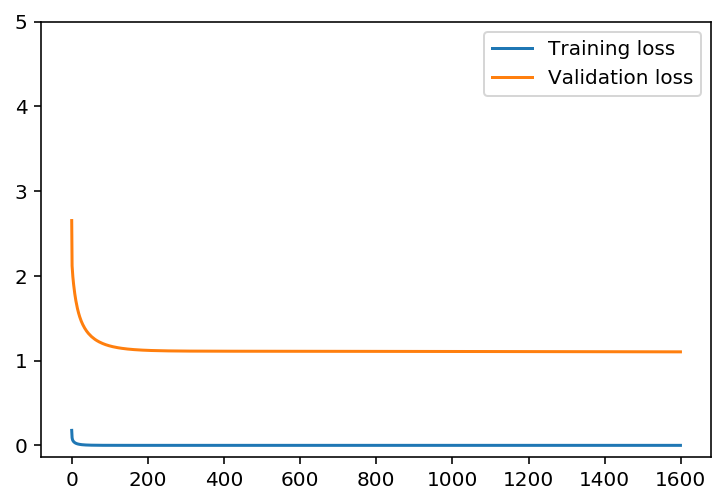

In [14]:
plt.plot(losses['train'], label='Training loss')
plt.plot(losses['validation'], label='Validation loss')
plt.legend()
plt.ylim(top=5)
# plt.ylim(top=20000, bottom=-100000)

## Check out your predictions

Here, use the test data to view how well your network is modeling the data. If something is completely wrong here, make sure each step in your network is implemented correctly.

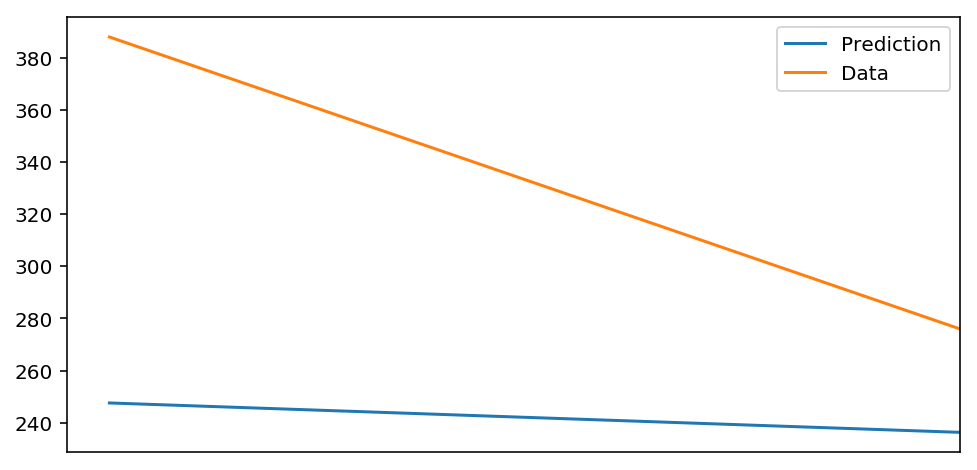

In [15]:
fig, ax = plt.subplots(figsize=(8,4))

mean, std = scaled_features['count1']
predictions = network.run(test_features)*std + mean
ax.plot(predictions[0], label='Prediction')
ax.plot((test_targets['count1']*std + mean).values, label='Data')
ax.set_xlim(right=len(predictions))
ax.legend()

dates = pd.to_datetime(medicines.loc[test_data.index]['dtmonth'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=45)

In [16]:
predictions

array([[247.55777106, 236.28421505]])

In [17]:
test_features

,dtmonth,count2,predicted_85.0,predicted_113.0,delivered_256.0,delivered_340.0,uf_Acre
21,1.099496,388,1,0,1,0,1
22,1.393547,276,0,1,0,1,1


In [18]:
scaled_features

{'dtmonth': [6.260869565217392, 3.4007671768741163],
 'count1': [291.7391304347826, 160.17354718364487]}

## Result: 
 
Considering 60% of safety range the **BNAFARIUNS** predicted 395,2(247.55777106*1,6); 377,6(236.28421505*1,6). Meaning just 7 extra medicines (from 388 (real) to 395 (predicted)) for for 2018-10 and 101 medicines for 2018-11. **Question**: Was it model prediction a good one?

> **Note:** The time frame was too short, creating fictional data for more months increased the assertivity.


### Answer 

*DAF Resp*: 

# Sample with better data

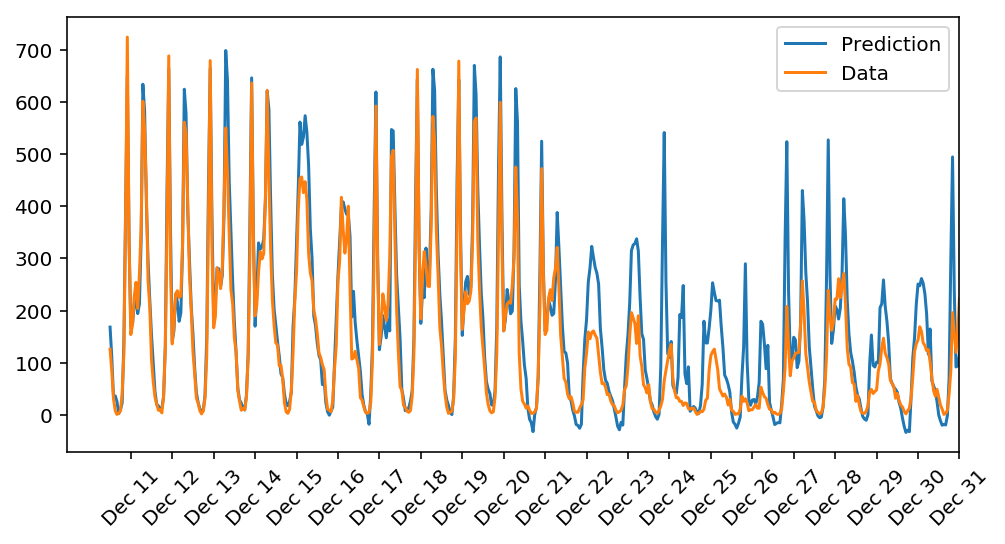

# Training with better data (loss decay)

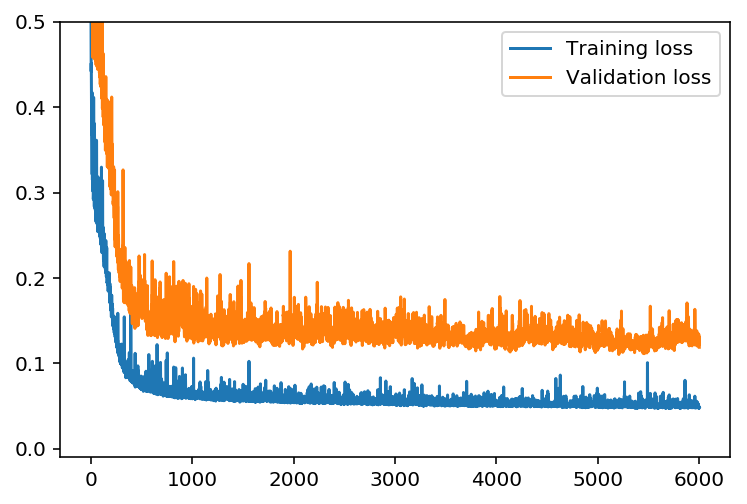

# DataPlot
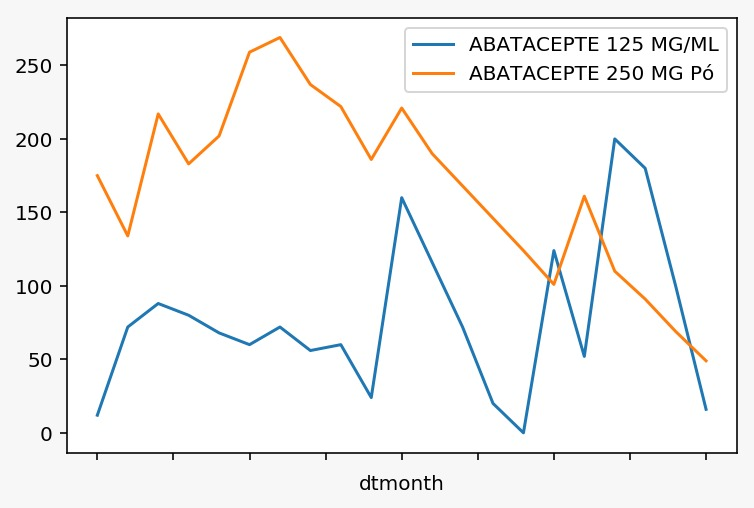


# Raw Training
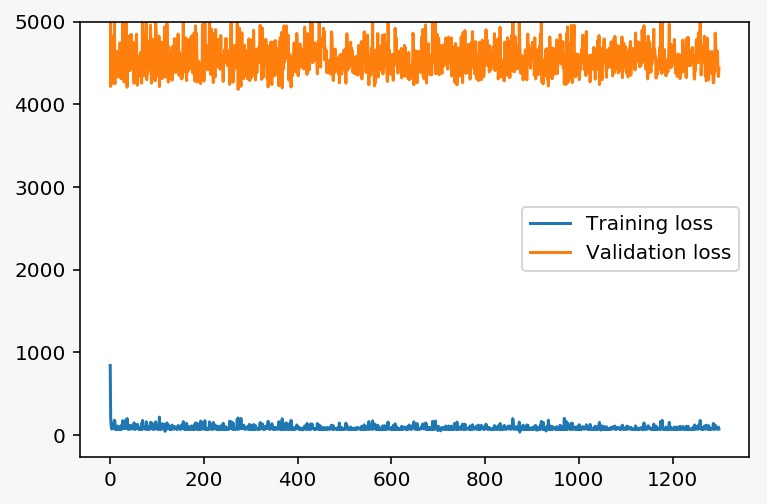



# Normalized
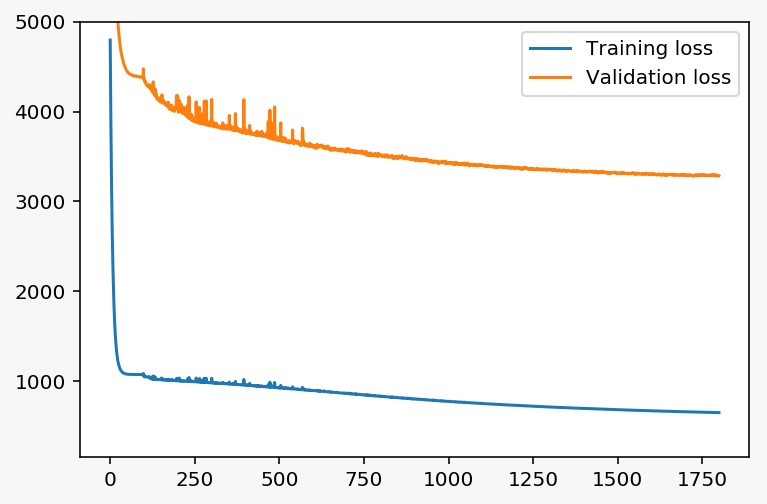


# Normalized2
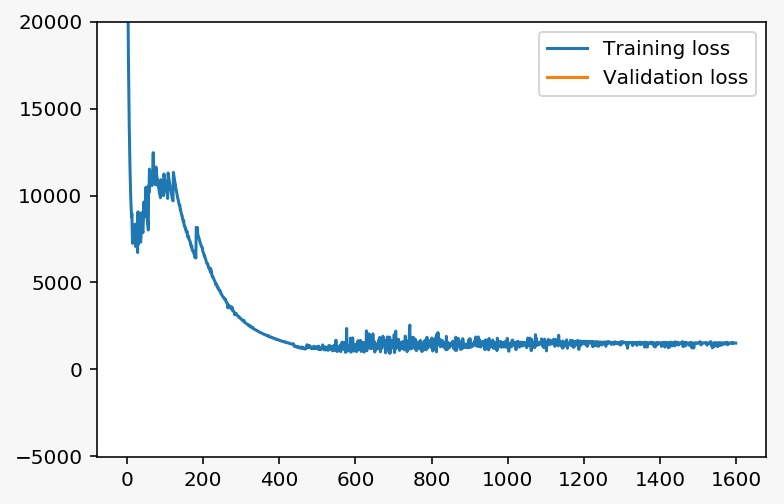


# Denormalized
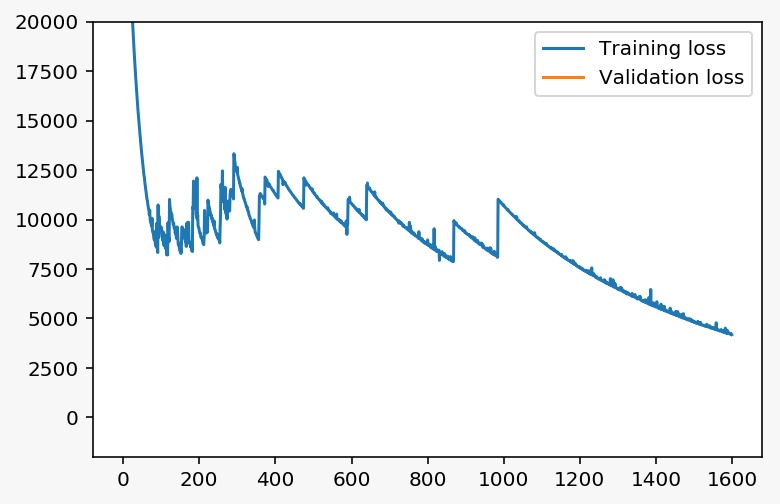


# Ficticional
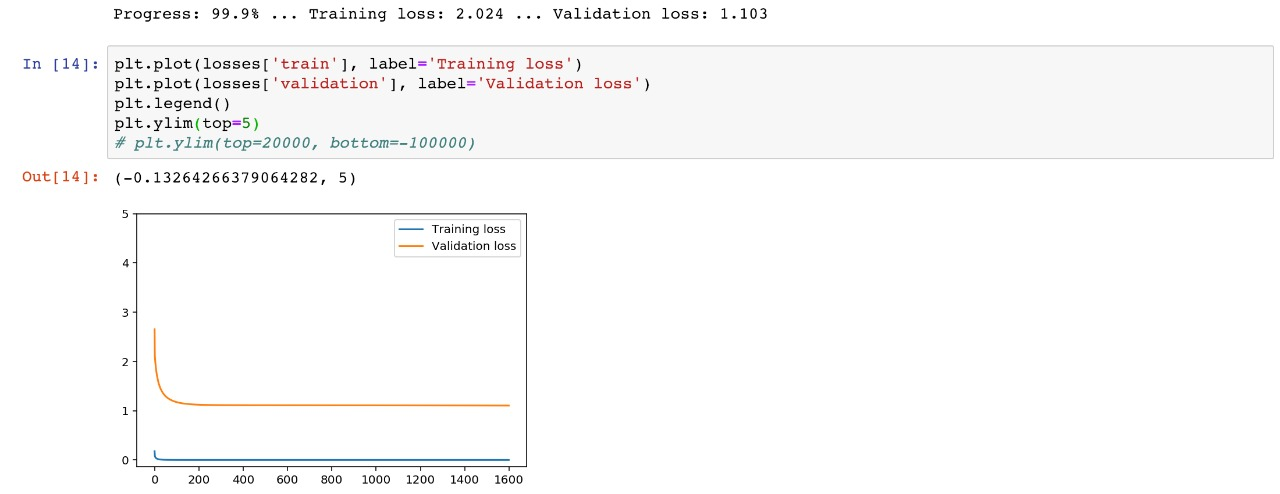


# Final Prediction
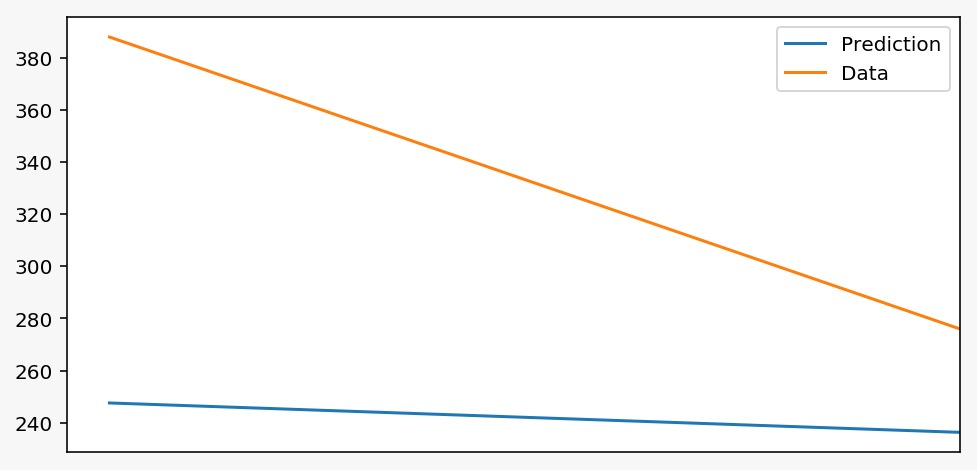